# Car prices prediction

## Introduction


In this notebook, four ML models will be compared on a regression task.\
The task consists in predicting the price of used cars, given the following features:
* Manufacturer
* Model
* Year
* Transmission
* Mileage
* Type of fuel
* Miles per Gallon (mpg)
* Engine size

The models are:

* Neural Network
* Random Forest Regressor
* Linear Regression
* XGB (eXtreme Gradient Boost) Regressor

These models will be compared using the following metrics:
* Mean Absolute Error (MAE)
* $R^2$ Score, defined as
  * $1 - \frac{u}{v}$, where $u$ is the sum of the residuals, so $\sum_{i=1}^n
{(y_{true}^{(i)} - y_{pred}^{(i)})^2}$, and $v$ is equal to $\sum_{i=0}^n {(y_{true}^{(i)} - E[y_{true}])^2}$
* Number of outliers

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Keras Tuner is a tool for automatic hyperparameters tuning:

In [2]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.2 MB/s eta 0:00:00


## Utils

The following function is used to count the number of outliers (a prediction is considered an outlier if the corresponding residual is over 10000):

In [60]:
def count_outliers(y_true, y_pred, threshold=10000):
    residuals = np.abs(y_true - y_pred)

    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    outlier_indices = np.where(residuals > threshold)[0]

    num_outliers = len(outlier_indices)

    return num_outliers

## Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
def load_dataset(filename):
 data = pd.read_csv(filename)
 X = data.drop('price', axis=1)
 y = data['price']
 return X, y


X, y = load_dataset("drive/MyDrive/progetto-ML/car_prices.csv")

We can visualize X:

In [5]:
X.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0


And y:

In [6]:
y.head()

0    12500
1    16500
2    11000
3    16800
4    17300
Name: price, dtype: int64

## Data Preprocessing

Let's check if the datasets X and y contain any null/NaN value:

In [7]:
X_null = X.isnull().values.any()
y_null = y.isnull().values.any()

if (X_null):
    print('There are invalid entries in X')
else:
    print('There are not invalid entries in X')

if (y_null):
    print('There are invalid entries in y')
else:
    print('There are not invalid entries in y')

There are not invalid entries in X
There are not invalid entries in y


The possible values for the attributes "manufacturer", "model", "transmission" and "fuelType", are the following:


In [8]:
manufacturer_values = X['manufacturer'].unique()
model_values = X['model'].unique()
transmission_values = X['transmission'].unique()
fuel_values = X['fuelType'].unique()

print(manufacturer_values)
print(model_values)
print(transmission_values)
print(fuel_values)

['Audi' 'BMW' 'Toyota' 'Mercedes']
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7' ' 5 Series' ' 6 Series' ' 1 Series' ' 7 Series'
 ' 2 Series' ' 4 Series' ' X3' ' 3 Series' ' X5' ' X4' ' i3' ' X1' ' M4'
 ' X2' ' X6' ' 8 Series' ' Z4' ' X7' ' M5' ' i8' ' M2' ' M3' ' M6' ' Z3'
 ' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser' ' SLK' ' S Class' ' SL CLASS'
 ' G Class' ' GLE Class' ' GLA Class' ' A Class' ' B Class' ' GLC Class'
 ' C Class' ' E Class' ' GL Class' ' CLS Class' ' CLC Class' ' CLA Class'
 ' V Class' ' M Class' ' CL Class' ' GLS Class' ' GLB Class' ' X-CLASS'
 '180' ' CLK' ' R Class' '230' '220' '200']
['Manual' 'Automatic' 'Semi-Auto' 'Other']
['Petrol' 'Diesel' 'Hybrid' 'Other' 'Electric']


These are categorical attributes. Let's divide features in categorical and numerical:

In [9]:
features_num = [
    'year',
    'mileage',
    'mpg',
    'engineSize',
]

features_cat = [
    'manufacturer',
    'model',
    'transmission',
    'fuelType'
]

We can plot histograms for numerical features and bar charts for categorical ones:

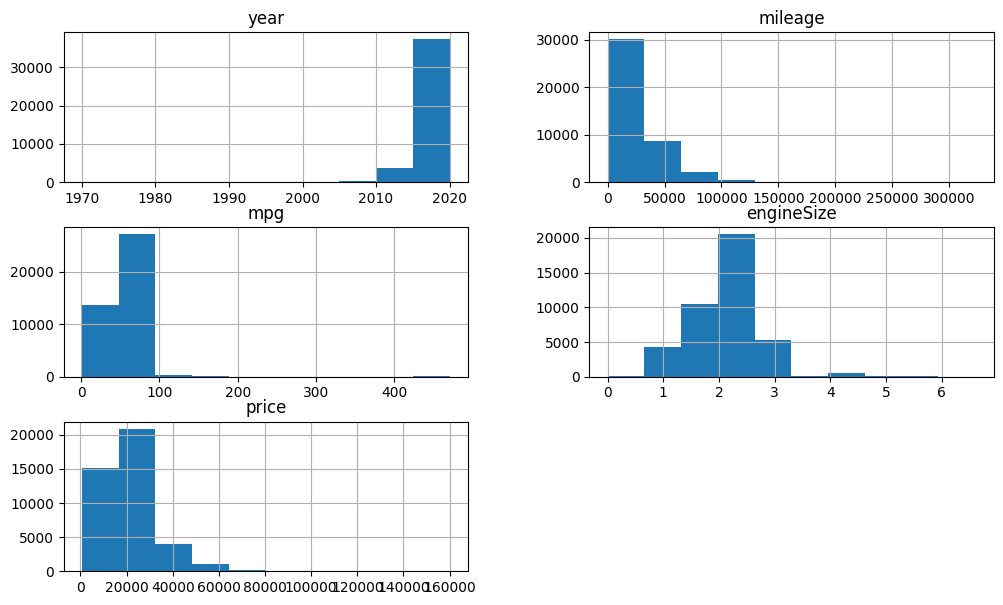

In [10]:
combined = X[features_num].assign(price=y)
combined.hist(figsize = (12,7))
plt.show()

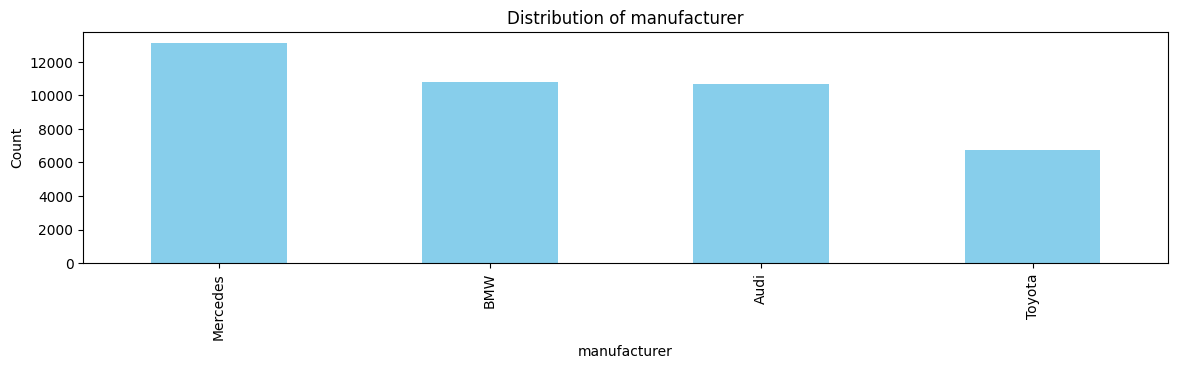

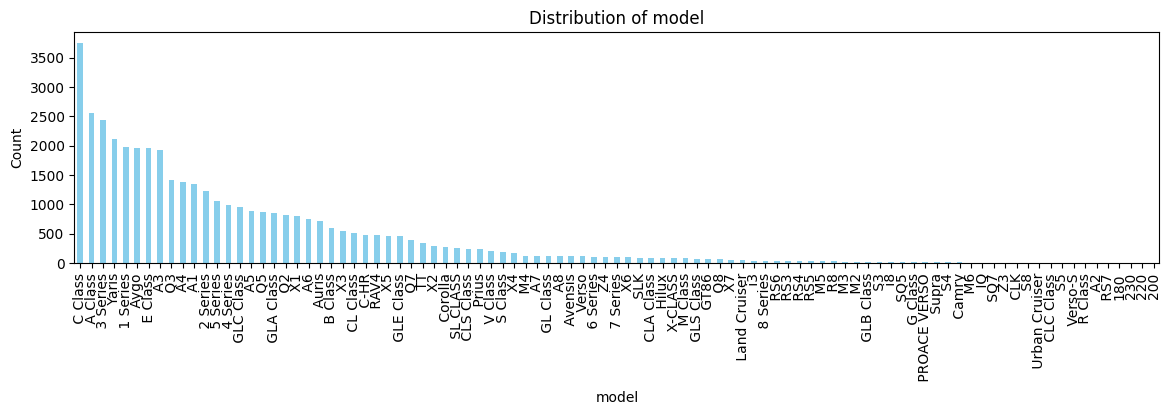

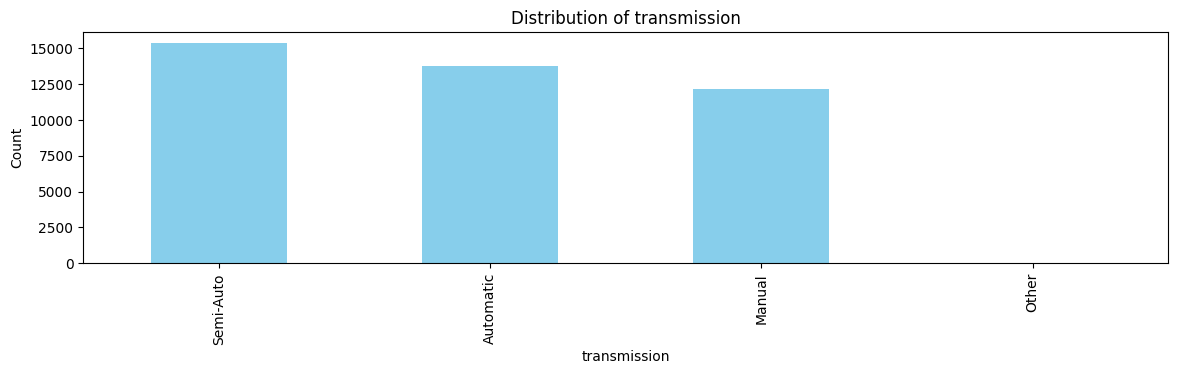

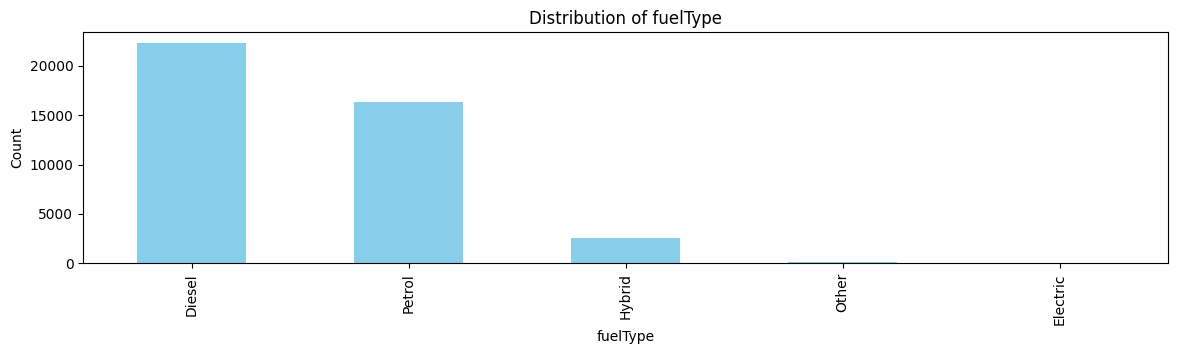

In [11]:
for column in features_cat:
    X[column].value_counts().plot(kind='bar', figsize=(14, 3), color='skyblue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

Machine learning and deep learning models require all input and output variables to be numeric. So we need to encode all categorical features to numerical ones. We're doing this using sklearn's OneHotEncoder:

In [12]:
X_cat = X[features_cat]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(features_cat))
X = pd.concat([X.drop(features_cat, axis=1), X_encoded], axis=1)

The new encoding becomes:

In [13]:
X.describe()

,year,mileage,mpg,engineSize,manufacturer_Audi,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,model_ 1 Series,model_ 2 Series,...,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,...,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000
mean,2017.099622,23766.754733,55.634063,1.962366,0.258268,0.261003,0.317605,0.163124,0.047669,0.029754,...,0.000024,0.333559,0.294533,0.000073,0.371835,0.539728,0.000073,0.061541,0.003583,0.395076
std,2.247246,22627.617263,20.721036,0.602423,0.437687,0.439187,0.465551,0.369483,0.213067,0.169909,...,0.004920,0.471490,0.455838,0.008522,0.483300,0.498425,0.008522,0.240322,0.059752,0.488873
min,1970.000000,1.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,6215.500000,45.600000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,17467.500000,54.300000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,34221.250000,64.200000,2.100000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2020.000000,323000.000000,470.800000,6.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now, we can split the dataset in training set and testing set, using a 75/25 split. Moreover, it's good practice to standardize data to zero mean and unit variance.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Neural Network

The first model we are going to consider is a neural network. In order to find the best hyperparameters, we're using the automatic tuner keras_tuner.
The hyperparameters we want to determine are:
* Weight initializer;
* Number of layers;
* Number of units in each layer;
* Learning rate.

In [22]:
def model_builder(hp):
  NN_model = Sequential()

  NN_model.add(
      Dense(units=112,
            input_dim = X_train.shape[1],
            activation='relu',
            kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal'])
            )
      )

  for i in range(hp.Int("num_layers", 1, 5)):
    NN_model.add(
        Dense(
        units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=5),
                activation="relu",
                kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal'])
          )
    )

  NN_model.add(
      Dense(units=1,
            kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal']),
            activation='linear')
      )

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  NN_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  return NN_model

In [23]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=350,
                     directory='/content/drive/My Drive/tuning',
                     project_name='ml-project'
                    )

early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=10)

tuner.search(X_train_scaled, y_train, epochs=350, validation_split=0.2, callbacks=[early_stopping])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from /content/drive/My Drive/tuning/ml-project/tuner0.json


Once the tuning is complete, we can obtain the best hyperparameters.

In [24]:
from IPython.display import Markdown, display

units = []
for i in range(0, best_hps.get("num_layers")):
  units.append(best_hps.get(f"units_{i}"))

hyp_string = f"""
The hyperparameter search is complete.
* the optimal number of layers is {best_hps.get("num_layers")};
* the optimal number of units in each layer is: {' '.join(str(unit) for unit in units)};
* the optimal initializer is {best_hps.get("initializer")};
* the optimal number of epochs is {best_hps.get("tuner/epochs")};
* the optimal learning rate is {best_hps.get("learning_rate")};
* the optimal starting epoch is {best_hps.get("tuner/initial_epoch")};
"""

def printmd(string):
    display(Markdown(string))

printmd(hyp_string)


The hyperparameter search is complete.
* the optimal number of layers is 2;
* the optimal number of units in each layer is: 85 15;
* the optimal initializer is glorot_uniform;
* the optimal number of epochs is 350;
* the optimal learning rate is 0.01;
* the optimal starting epoch is 117;


Now, we create a model with the best hyperparameters, and we train it on our training set:

In [25]:
model = tuner.hypermodel.build(best_hps)
model.summary()
model.fit(X_train_scaled, y_train, epochs=best_hps.get("tuner/epochs"), initial_epoch=best_hps.get("tuner/initial_epoch"), batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 112)               12656     
                                                                 
 dense_1 (Dense)             (None, 85)                9605      
                                                                 
 dense_2 (Dense)             (None, 15)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 23567 (92.06 KB)
Trainable params: 23567 (92.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 118/350
775/775 [==============================] - 3s 3ms/step - loss: 4032.9836 - mean_absolute_error: 4032.9836 - val_loss: 2266.4761 - val_mean

Let's test the neural network performances on the testing set:

In [27]:
from sklearn.metrics import mean_absolute_error

nn_predictions = model.predict(X_test_scaled)

nn_mae = mean_absolute_error(y_test, nn_predictions)
print(f'Mean Absolute Error on Test Set: {nn_mae}')

323/323 [==============================] - 0s 1ms/step
Mean Absolute Error on Test Set: 1589.769557849082


### Results

The mean absolute error on the testing set is about $1600. To better visualize the performances, we can observe a scatter plot:

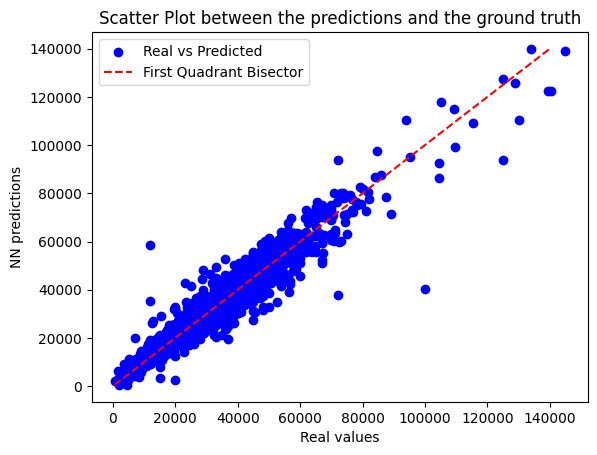

In [37]:
plt.scatter(y_test, nn_predictions, color='blue', label='Real vs Predicted')

plt.xlabel('Real values')
plt.ylabel('NN predictions')
plt.title('Scatter Plot between the predictions and the ground truth')

x_bisector = np.linspace(min(nn_predictions), max(nn_predictions), 100)
y_bisector = x_bisector
plt.plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')

plt.legend()

plt.show()

From the scatter plot, we can see that the predictions oscillate around the bisector, and this confirms the average good behavior of the model.\
Then, we can plot the residual errors in function of the predictions:

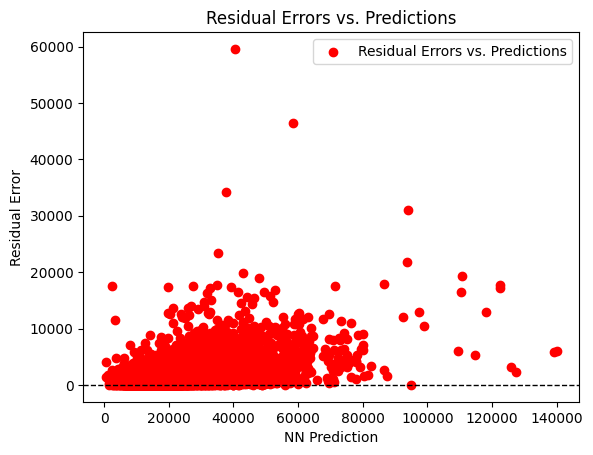

In [29]:
residuals = np.abs(y_test - nn_predictions.flatten())
residuals = np.array(residuals)
nn_predictions = np.array(nn_predictions)

plt.scatter(nn_predictions, residuals, color='red', label='Residual Errors vs. Predictions')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('NN Prediction')
plt.ylabel('Residual Error')
plt.title('Residual Errors vs. Predictions')
plt.legend()

plt.show()

The previous graph confirms that most points are well classified, but there are some outliers.

The $R^2$ score achieved by this model is:

In [30]:
from sklearn.metrics import r2_score

nn_r2 = r2_score(y_true=y_test, y_pred=nn_predictions)
print(nn_r2)

0.9507599474021146


The number of outliers is:

In [69]:
nn_outliers = count_outliers(y_test, nn_predictions.flatten())
print(nn_outliers)

90


## Random Forest

Now, we are going to try a random forest model, in order to compare it with the previous NN based model.\
For the hyperparameters tuning, we're using RandomizedSearchCV.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

The best model has:


*   400 estimators;
*   min_samples_split equal to 7;
*   min_samples_leaf equal to 1.



In [33]:
import time

best_model = RandomForestRegressor(n_estimators=400, min_samples_split=7, min_samples_leaf=1)

start_time = time.time()
best_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

predicted_prices = best_model.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test , predicted_prices)
print('Random forest test MAE =', rf_mae)

Random forest test MAE = 1441.7714083246035


### Results
We get a mean absolute error of about $1440, so the Random Forest model performs better than the NN.

As we've done in the case of the NN, we can observe a scatter plot:

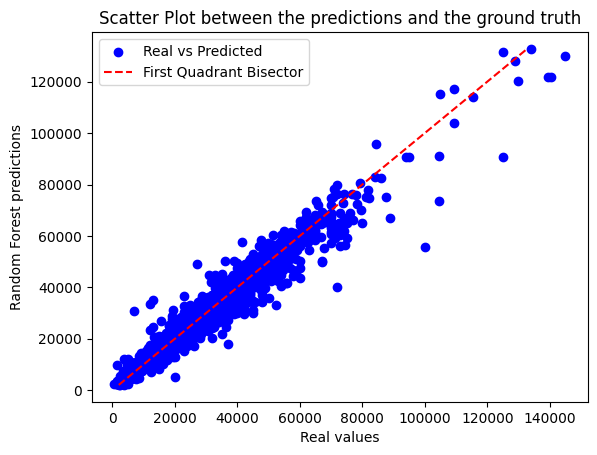

In [35]:
plt.scatter(y_test, predicted_prices, color='blue', label='Real vs Predicted')

plt.xlabel('Real values')
plt.ylabel('Random Forest predictions')
plt.title('Scatter Plot between the predictions and the ground truth')

x_bisector = np.linspace(min(predicted_prices), max(predicted_prices), 100)
y_bisector = x_bisector
plt.plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')

plt.legend()

plt.show()

Similarly to the NN case, with RF we don't have predicted prices that differs a lot from the ground truth.\
We can further visualize this plotting the predictions against the residuals:

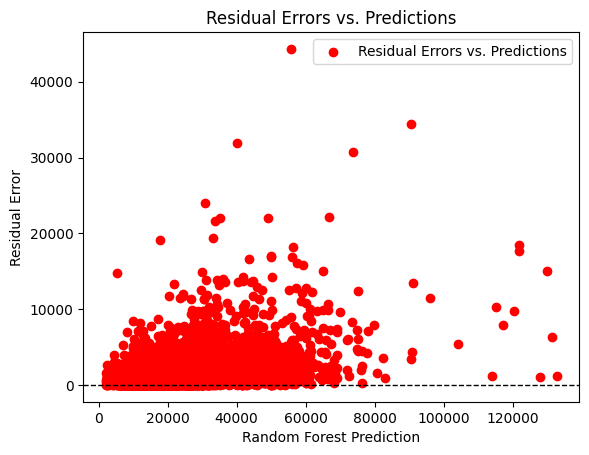

In [36]:
residuals = np.abs(y_test - predicted_prices.flatten())
residuals = np.array(residuals)
predicted_prices = np.array(predicted_prices)

plt.scatter(predicted_prices, residuals, color='red', label='Residual Errors vs. Predictions')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Random Forest Prediction')
plt.ylabel('Residual Error')
plt.title('Residual Errors vs. Predictions')
plt.legend()

plt.show()

From this last graph, it can be seen that we still have a strong presence of outliers and mispredicted prices, but with a lower impact, as compared to the NN case.

This model achieves a $R^2$ score of:



In [38]:
print('Training score: {}'.format(best_model.score(X_train_scaled, y_train)))

rf_r2 = best_model.score(X_test_scaled, y_test)

print('Test score: {}'.format(rf_r2))

Training score: 0.9846205092032826
Test score: 0.9603477375433022


The number of outliers is:

In [74]:
rf_outliers = count_outliers(y_test, predicted_prices)
print(rf_outliers)

70


### Feature Selection
In the case of Random Forest, we can easily perform a feature selection. This allows us to simplify the model, remove the useless features and make the training process faster.

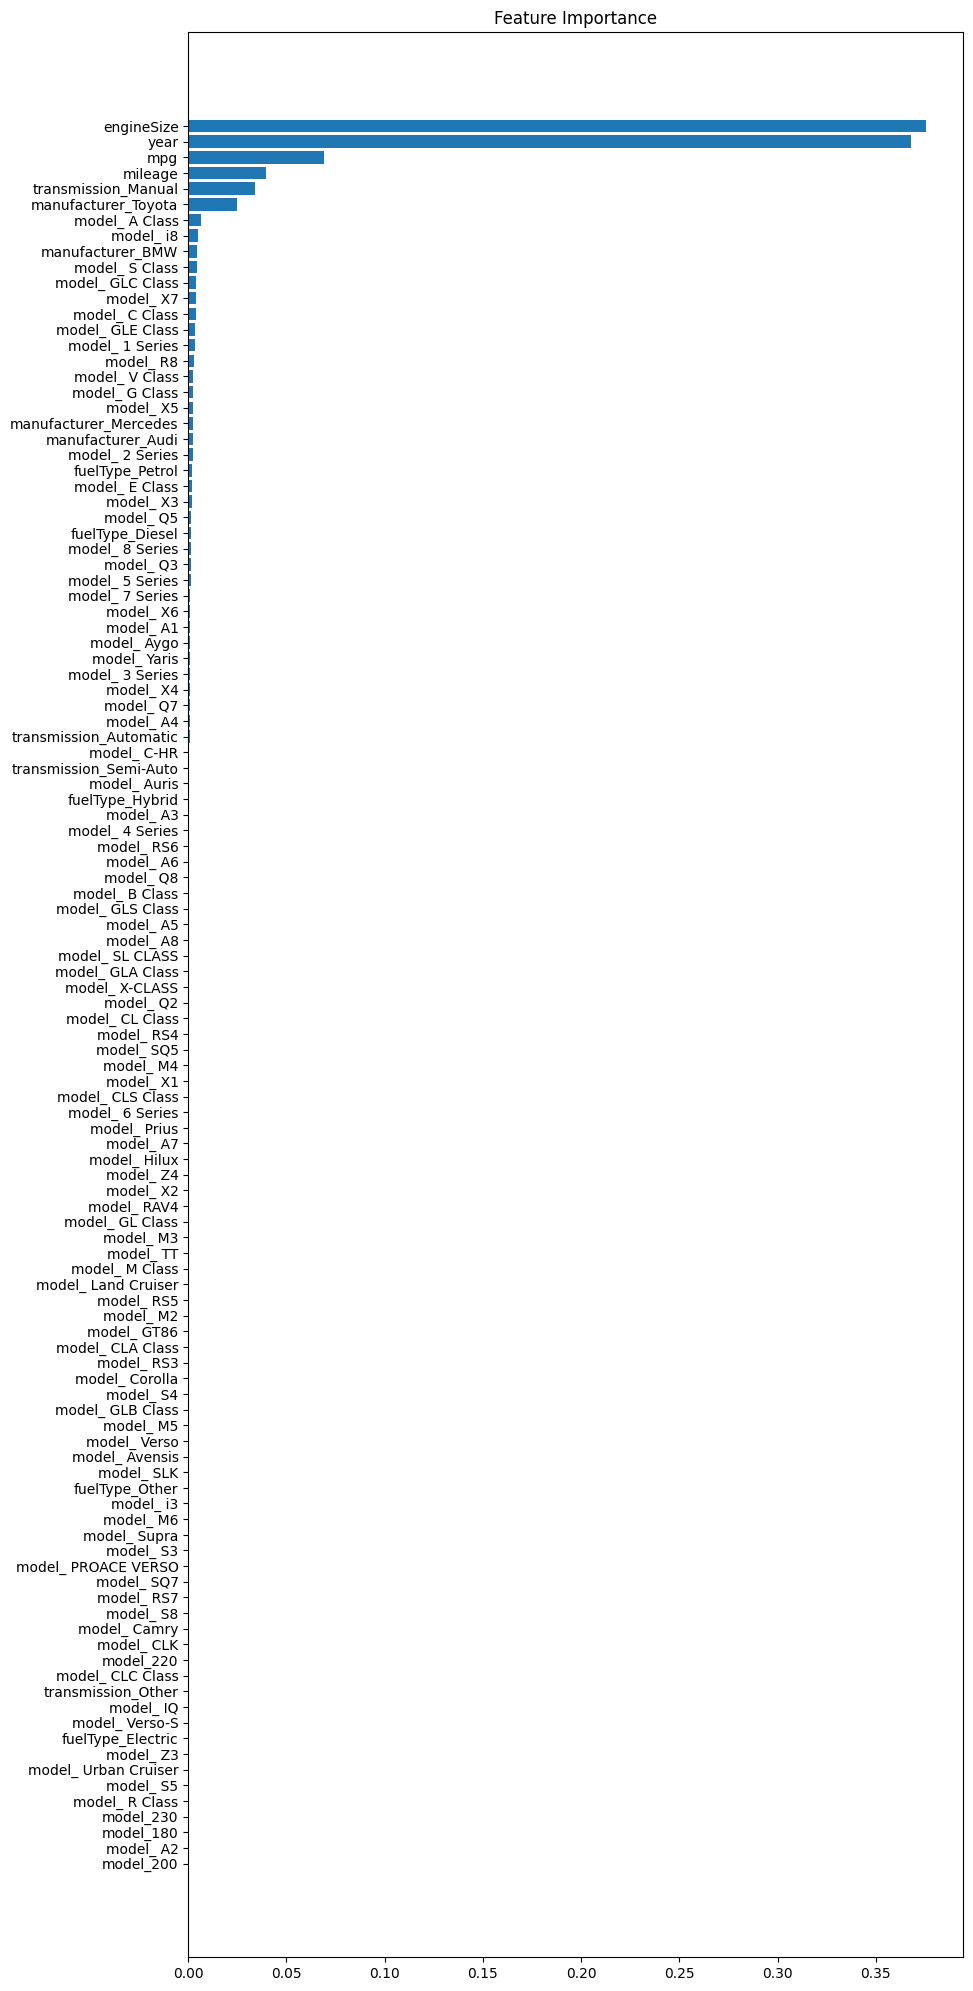

In [40]:
f_i = list(zip(X_train.columns ,best_model.feature_importances_))
f_i.sort(key = lambda x : x[1])

plt.figure(figsize=(10, 25))
plt.title('Feature Importance')
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()



In [41]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(best_model, max_features=10)
sel.get_support()

selected_feat= X_train.columns[(sel.get_support())]

X_train_selected = sel.transform(X_train_scaled)
X_test_selected = sel.transform(X_test_scaled)


In [42]:
import time

best_model_fs = RandomForestRegressor(n_estimators = 400, min_samples_split=7, min_samples_leaf=1)

start_time = time.time()
best_model_fs.fit(X_train_selected, y_train)
training_time_fs = time.time() - start_time

predicted_prices_after_fs = best_model_fs.predict(X_test_selected)
rf_fs_mae = mean_absolute_error(y_test , predicted_prices_after_fs)
print('Random forest test MAE = ', rf_fs_mae)

Random forest test MAE =  2083.655121039175


As we can see, the training time is reduced by a factor of (about) 3:




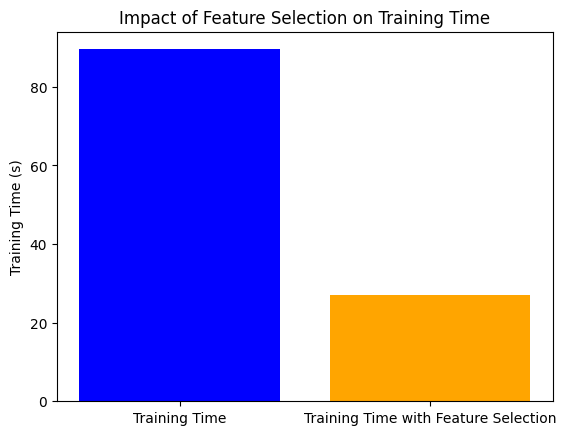

In [43]:
plt.bar(['Training Time', 'Training Time with Feature Selection'], [training_time, training_time_fs], color=['blue', 'orange'])
plt.ylabel('Training Time (s)')
plt.title('Impact of Feature Selection on Training Time')
plt.show()

## Linear Regression


The third model we're considering is a simple Linear Regression model:

In [44]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

predicted_prices_lr = lr.predict(X_test)
lr_mae = mean_absolute_error(y_test , predicted_prices_lr)
print('Linear regression test MAE = ', lr_mae)

Linear regression test MAE =  3022.6587255798886


As regards Linear Regression, the mean absolute error is way higher as compared to the models previously analyzed.

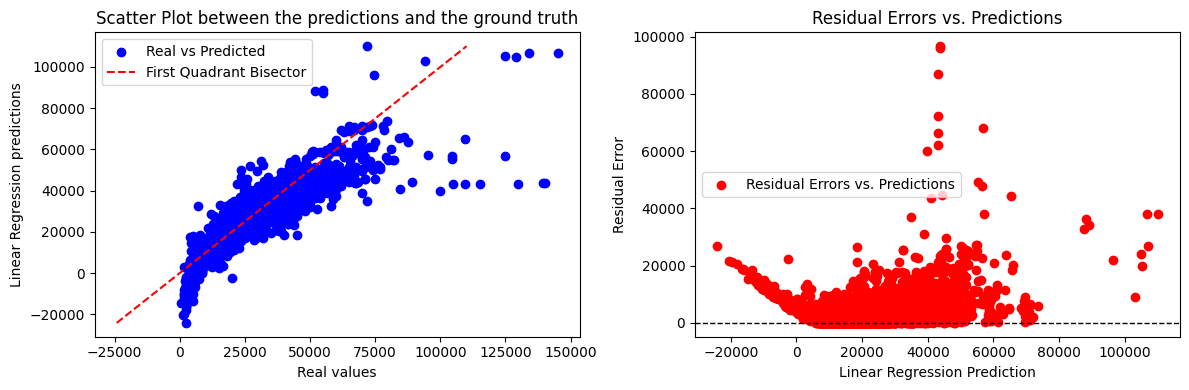

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plot
axs[0].scatter(y_test, predicted_prices_lr, color='blue', label='Real vs Predicted')
axs[0].set_xlabel('Real values')
axs[0].set_ylabel('Linear Regression predictions')
axs[0].set_title('Scatter Plot between the predictions and the ground truth')
x_bisector = np.linspace(min(predicted_prices_lr), max(predicted_prices_lr), 100)
y_bisector = x_bisector
axs[0].plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')
axs[0].legend()

# Residuals vs. Predictions
residuals = np.abs(y_test - predicted_prices_lr.flatten())
axs[1].scatter(predicted_prices_lr, residuals, color='red', label='Residual Errors vs. Predictions')
axs[1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[1].set_xlabel('Linear Regression Prediction')
axs[1].set_ylabel('Residual Error')
axs[1].set_title('Residual Errors vs. Predictions')
axs[1].legend()

plt.tight_layout()
plt.show()

The score of this model is:

In [46]:
print('Training score: {}'.format(lr.score(X_train, y_train)))

lr_r2 = lr.score(X_test, y_test)

print('Test score: {}'.format(lr_r2))

Training score: 0.8335248365484338
Test score: 0.8226162075752259


The number of outliers is:

In [75]:
lr_outliers = count_outliers(y_test, predicted_prices_lr)
print(lr_outliers)

383


## XGB Regressor

The fourth and last model is an XGB Regressor, based on the Extreme Gradient Boosting algorithm.\
Similarly to what we did with Random Forest, we're using RandomizedSearchCV to get the best hyperparameters.

In [15]:
from xgboost import XGBRegressor

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'max_leaves': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    'grow_policy': ['depthwise', 'lossguide'],
}

xgb = XGBRegressor()

rand_search = RandomizedSearchCV(estimator=xgb,
                                 param_distributions=param_dist,
                                 n_iter=100,
                                 scoring='neg_mean_absolute_error',
                                 cv=5,
                                 random_state=123)

rand_search.fit(X_train_scaled, y_train)

print("Best hyperparameters:", rand_search.best_params_)

Best hyperparameters: {'n_estimators': 1400, 'min_child_weight': 3, 'max_leaves': 50, 'max_depth': 21, 'learning_rate': 0.05, 'grow_policy': 'lossguide'}


In [49]:
XGBModel = XGBRegressor(n_estimators=1400, min_child_weight=3, max_leaves=50, max_depth=21, learning_rate=0.05, grow_policy='lossguide')

XGBModel.fit(X_train_scaled,y_train,verbose=True)

XGBpredictions = XGBModel.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test, XGBpredictions)
print('XGBoost validation MAE = ', xgb_mae)

XGBoost validation MAE =  1381.2313673031044


In [50]:
print('Training score: {}'.format(XGBModel.score(X_train_scaled, y_train)))

xgb_r2 = XGBModel.score(X_test_scaled, y_test)

print('Test score: {}'.format(xgb_r2))

Training score: 0.984875148279015
Test score: 0.9643514100219258


The number of outliers is:

In [72]:
xgb_outliers = count_outliers(y_test, XGBpredictions)
print(xgb_outliers)

63


## Conclusions

The following graphs compare the performance of the models seen, according to the metrics defined in the introduction:

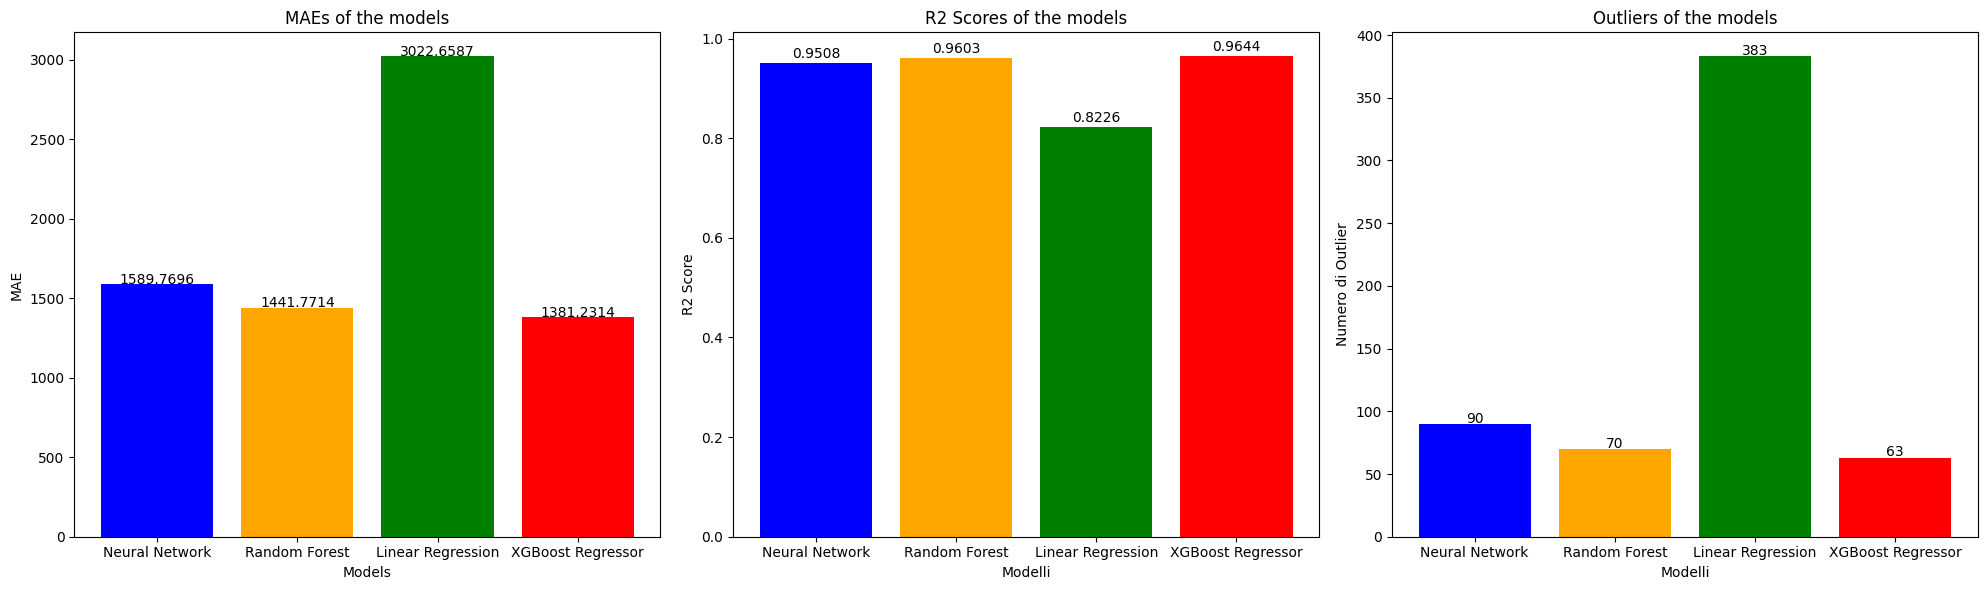

In [90]:
model_names = ['Neural Network', 'Random Forest', 'Linear Regression', 'XGBoost Regressor']
mae_values = [nn_mae, rf_mae, lr_mae, xgb_mae]
r2_values = [nn_r2, rf_r2, lr_r2, xgb_r2]
outliers_values = [nn_outliers, rf_outliers, lr_outliers, xgb_outliers]

# MAE
plt.figure(figsize=(20, 6))
plt.subplot(131)
bars = plt.bar(model_names, mae_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAEs of the models')

for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.4f}', ha='center', color='black')

# R2 score
plt.subplot(132)
bars = plt.bar(model_names, r2_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Modelli')
plt.ylabel('R2 Score')
plt.title('R2 Scores of the models')

for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.4f}', ha='center', color='black')

# outliers
plt.subplot(133)
bars = plt.bar(model_names, outliers_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Modelli')
plt.ylabel('Numero di Outlier')
plt.title('Outliers of the models')

for bar, value in zip(bars, outliers_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value}', ha='center', color='black')

plt.tight_layout()
plt.show()

In [79]:
best_MAE = model_names[np.argmin(mae_values)]
best_r2 = model_names[np.argmax(r2_values)]
best_outliers = model_names[np.argmin(outliers_values)]

string = f"""
Model with the lowest MAE:
* {best_MAE}

Model with the highest $R^2$ Score:
* {best_r2}

Model with the lowest number of outliers:
* {best_outliers}
"""

display(Markdown(string))


Model with the lowest MAE:
* XGBoost Regressor

Model with the highest $R^2$ Score:
* XGBoost Regressor

Model with the lowest number of outliers:
* XGBoost Regressor


The best model, for this task, is XGB Regressor.testo in grassetto